# Standard Particle Filter Demo

This notebook demonstrates a **bootstrap particle filter** on a 1-D linear
Gaussian state-space model using the `dpf.SMC` framework.

**What it does:** A sinusoidal true signal is observed through additive Gaussian
noise. The particle filter tracks the hidden state using a simple random-walk
transition model ($F = I$) and direct observation model ($H = I$), running
4 independent batches in parallel with 500 particles each.

**What you will see:**
1. How the `dpf` package implements the standard SMC algorithm (Corenflos et al. 2021).
2. Filtering results — particle filter estimates vs. true signal and noisy observations.
3. Effective sample size (ESS) over time and how resampling keeps the filter healthy.
4. Why a misspecified random-walk model can still track a sinusoidal signal.

In [1]:
import sys
sys.path.append("..")

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

from dpf import SMC, State
from dpf.observation.linear import LinearObservationModel
from dpf.transition import RandomWalkModel
from dpf.proposal.bootstrap import BootstrapProposal
from dpf.resampling.criterion import NeffCriterion
from dpf.resampling.standard.multinomial import MultinomialResampler

tfd = tfp.distributions
np.random.seed(42)

## 1. Synthetic Data

`batch_size` controls how many **independent filtering problems** are solved
in parallel. All batches share the same true signal $x_t = \sin(\cdot)$ and
the same model (F, H, noise distributions), but each batch receives its own
independent observation noise realization. This is equivalent to running
`batch_size` separate particle filters simultaneously — useful for:

- **Variance assessment**: comparing filter estimates across batches reveals
  how much the result varies due to observation noise and particle randomness.

Tensor layout through the pipeline:

| Tensor | Shape |
|--------|-------|
| `observations` | `[T, batch_size, obs_dim]` |
| `particles` | `[batch_size, n_particles, state_dim]` |
| `log_weights` | `[batch_size, n_particles]` |

In [2]:
T = 100
batch_size = 4
true_signal = np.sin(np.linspace(0., 4., T))
observations_np = true_signal[:, np.newaxis] + np.random.normal(0., 0.5, (T, batch_size))

## 2. Build Model & Filter

In [3]:
F = tf.eye(1, dtype=tf.float64)
H = tf.eye(1, dtype=tf.float64)

transition_noise = tfd.MultivariateNormalTriL(
    loc=tf.zeros([1], dtype=tf.float64),
    scale_tril=tf.constant([[0.5]], dtype=tf.float64),
)
observation_noise = tfd.MultivariateNormalTriL(
    loc=tf.zeros([1], dtype=tf.float64),
    scale_tril=tf.constant([[0.5]], dtype=tf.float64),
)

smc = SMC(
    observation_model=LinearObservationModel(H, observation_noise),
    transition_model=RandomWalkModel(F, transition_noise),
    proposal_model=BootstrapProposal(RandomWalkModel(F, transition_noise)),
    resampling_criterion=NeffCriterion(threshold_ratio=0.5),
    resampling_method=MultinomialResampler(),
)

## 3. Run the Filter

In [4]:
n_particles = 500

initial_particles = tf.constant(
    np.random.randn(batch_size, n_particles, 1), dtype=tf.float64
)
initial_state = State(
    particles=initial_particles,
    log_weights=tf.fill([batch_size, n_particles],
                        -tf.math.log(tf.cast(n_particles, tf.float64))),
)

# Observations: [T, batch, obs_dim]
obs_tf = tf.constant(
    observations_np[:, :, np.newaxis], dtype=tf.float64
)

final_state, series = smc(initial_state, obs_tf, return_series=True)
for b in range(batch_size):
    print(f'Batch {b} final log-likelihood: {final_state.log_likelihoods[b].numpy():.2f}')

Batch 0 final log-likelihood: -99.56
Batch 1 final log-likelihood: -102.27
Batch 2 final log-likelihood: -107.88
Batch 3 final log-likelihood: -105.85


## 4. Plot Results

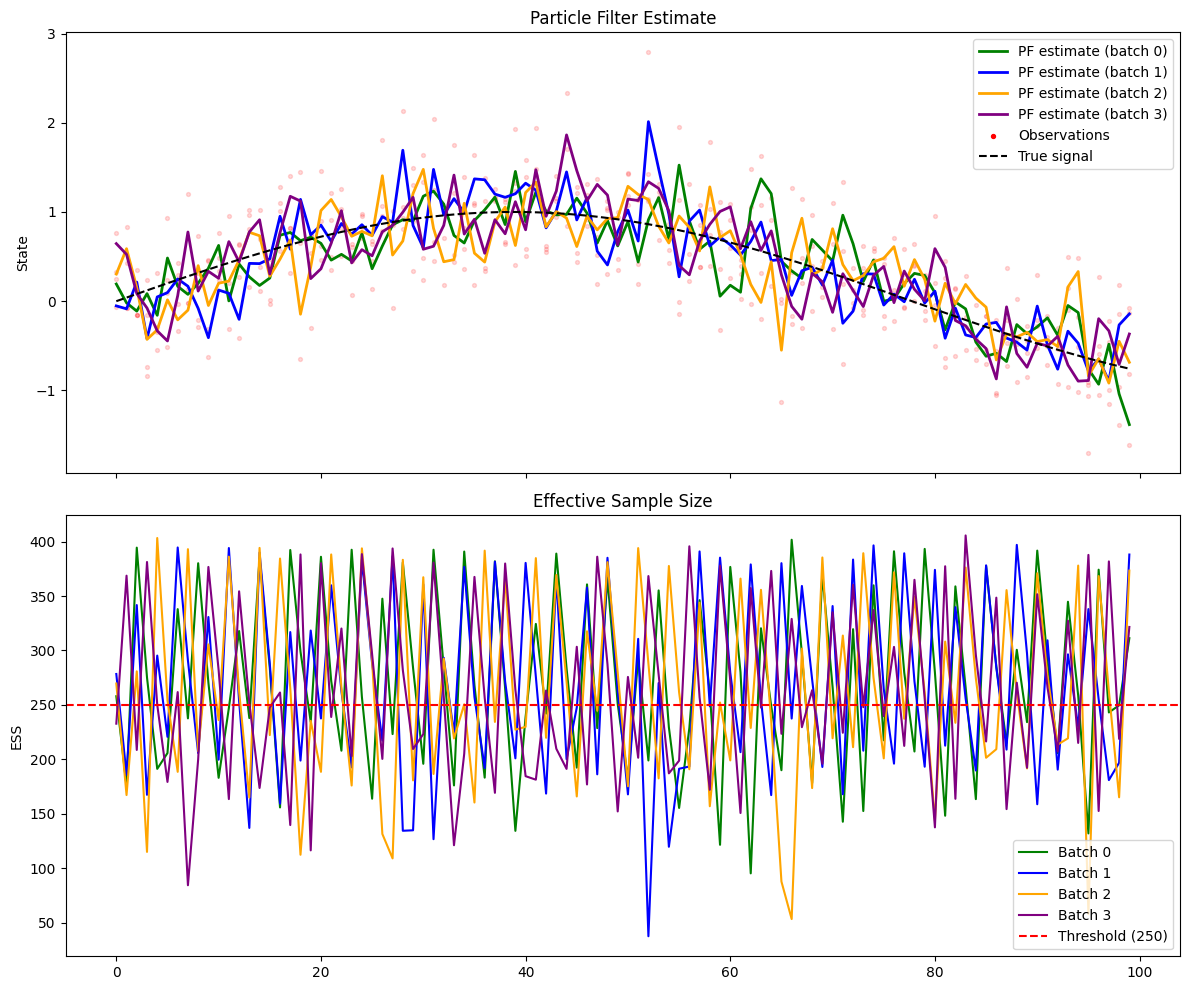

In [5]:
# Compute weighted mean estimate per batch
all_particles = series['particles'][:, :, :, 0].numpy()   # [T, batch, N]
all_weights = tf.nn.softmax(series['log_weights'], axis=-1).numpy()  # [T, batch, N]
filter_mean = np.sum(all_weights * all_particles, axis=2)  # [T, batch]

t = np.arange(T)
colors = ['green', 'blue', 'orange', 'purple']

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Panel 1: Filtering result
for b in range(batch_size):
    axes[0].scatter(t, observations_np[:, b], c='red', s=8, alpha=0.15)
    axes[0].plot(t, filter_mean[:, b], color=colors[b], lw=2, label=f'PF estimate (batch {b})')
axes[0].scatter([], [], c='red', s=8, label='Observations')
axes[0].plot(t, true_signal, 'k--', lw=1.5, label='True signal')
axes[0].legend(loc='upper right')
axes[0].set_ylabel('State')
axes[0].set_title('Particle Filter Estimate')

# Panel 2: ESS
for b in range(batch_size):
    ess = 1.0 / np.sum(all_weights[:, b, :] ** 2, axis=1)
    axes[1].plot(t, ess, color=colors[b], lw=1.5, label=f'Batch {b}')
axes[1].axhline(0.5 * n_particles, color='r', ls='--', label=f'Threshold ({0.5*n_particles:.0f})')
axes[1].legend()
axes[1].set_ylabel('ESS')
axes[1].set_title('Effective Sample Size')

plt.tight_layout()
plt.show()

## 5. Why F=H=I Works for a Sinusoidal Signal

The true signal is $x_t = \sin(\cdot)$, yet our state-space model assumes:

$$x_t = F\, x_{t-1} + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, Q) \qquad \text{(transition, with } F=I \text{)}$$
$$y_t = H\, x_t + v_t, \quad v_t \sim \mathcal{N}(0, R) \qquad \text{(observation, with } H=I \text{)}$$

This is a **random walk + direct observation** model — it has no knowledge of
sinusoidal dynamics. It still tracks the signal because:

1. **Small step-to-step increments.** The sinusoid changes slowly: consecutive
   values $x_t - x_{t-1}$ are much smaller than the transition noise $\sigma_Q = 0.5$.
   A random walk easily accommodates these small drifts.

2. **Observations anchor the particles.** At every step the likelihood
   $p(y_t \mid x_t)$ pulls particles towards the current observation, correcting
   any drift from the random walk prior.

3. **The filter acts as a local tracker**, not a predictor. It does not
   exploit the global sinusoidal structure; it simply follows the data
   one step at a time.

The plot below shows that the per-step increments of the true signal
($|\Delta x_t|$, blue) are well within the $\pm 2\sigma$ envelope of the
transition noise (red dashed), which is why the random walk prior is
"wide enough" to cover the true dynamics at every step.

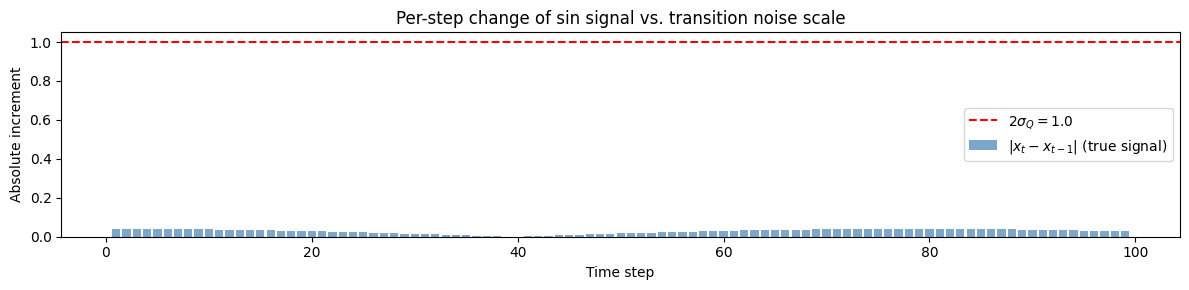

Max |Δx|: 0.0404,  Mean |Δx|: 0.0278,  2σ_Q: 1.0
All increments are well within the transition noise → random walk prior covers the true dynamics.


In [6]:
increments = np.abs(np.diff(true_signal))
sigma_q = 0.5

fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(np.arange(1, T), increments, color='steelblue', alpha=0.7, label=r'$|x_t - x_{t-1}|$ (true signal)')
ax.axhline(2 * sigma_q, color='red', ls='--', lw=1.5, label=rf'$2\sigma_Q = {2*sigma_q}$')
ax.set_xlabel('Time step')
ax.set_ylabel('Absolute increment')
ax.set_title('Per-step change of sin signal vs. transition noise scale')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Max |Δx|: {increments.max():.4f},  Mean |Δx|: {increments.mean():.4f},  2σ_Q: {2*sigma_q}")
print("All increments are well within the transition noise → random walk prior covers the true dynamics.")